In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import seaborn
import numpy as np

#%matplotlib inline
#%pdb

In [2]:
# Import data from csv and compute some properties
csv  = pd.read_csv('runtimes.csv', sep = ';')

In [3]:
def mask(df, key, value):
    return df[df[key] == value].drop(key, axis = 1)

In [4]:
versions = ['vc_enabled', 'vc_disabled', 'vc_removed', 'clang.0', 'clang.1', 'clang.3', 'gcc.0', 'gcc.1', 'gcc.3', 'native']
versionsOfInterest = ['vc_enabled', 'native', 'vc_removed', 'clang.3', 'gcc.3']
versionBaseline = 'vc_removed'

pixels = { 
    'input1': '384 × 480 pixels',
    'input2': '512 × 288 pixels',
    'input3': '200 × 200 pixels',
    'input4': '220 × 334 pixels',
    'input5': '512 × 384 pixels',
    'input6': '250 × 184 pixels',
    'input7': '1350 × 900 pixels',
    'input7big': '6000 × 4000 pixels'
}

#inputOrder = ['input6', 'input4', 'input2', 'input1', 'input5', 'input7', 'input7big'] # by size, w/o input3 (too small)
inputOrder = ['input3', 'input6', 'input4', 'input2', 'input1', 'input5', 'input7', 'input7big'] # by size
inputOrderIndex = dict(zip(inputOrder, range(len(inputOrder))))

In [5]:
def extract(filter, input):
    sf = mask(mask(csv, 'input', input), 'filter', filter)

    sfs = []
    for v in versionsOfInterest:
        tmp = mask(sf, 'version', v).rename(columns = { 'runtime[ms]': v })
        tmp = tmp.reset_index(drop = True)
        sfs.append(tmp)

    fused = pd.concat(sfs, axis = 1)
    
    return fused

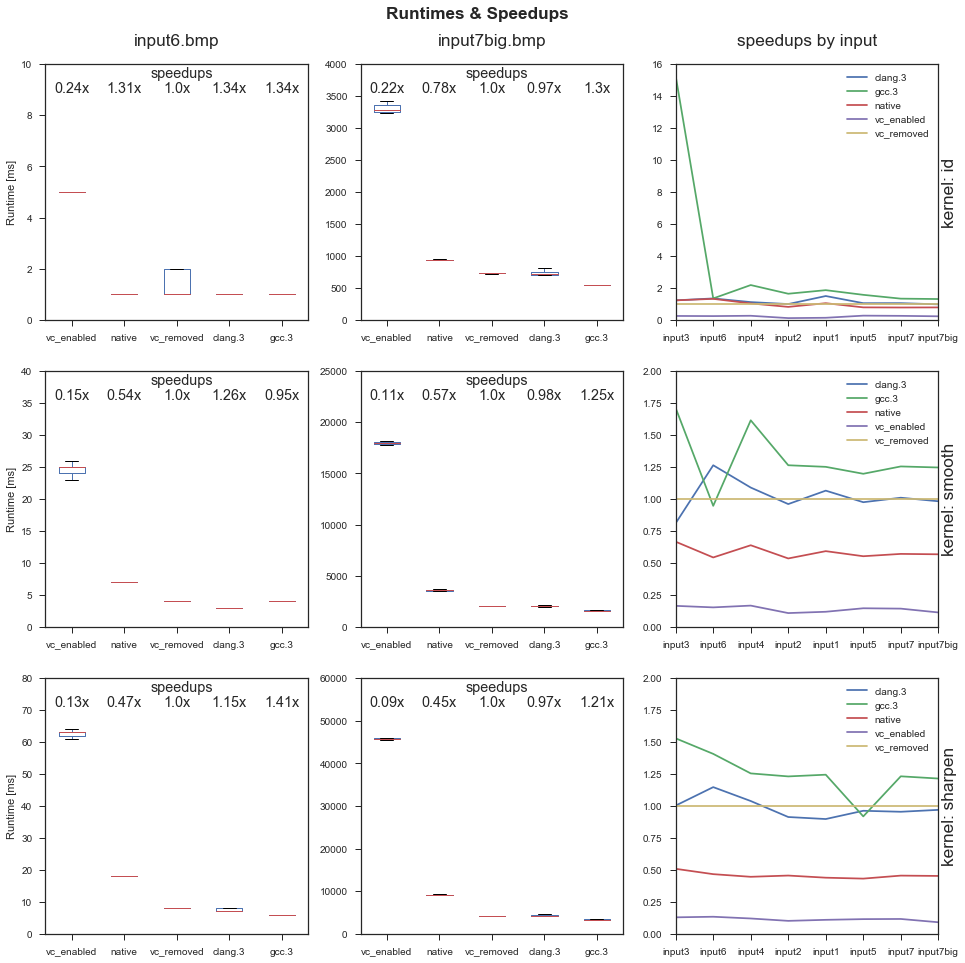

In [8]:
def plotSpeedupsByFilter(filter, ax):
    data = mask(csv, 'filter', filter)
    data = data[data['version'].isin(versionsOfInterest)].rename(columns = { 'runtime[ms]': 'runtime' })
    #data = data[data['input'] != 'input3']

    baselines = mask(data, 'version', versionBaseline).groupby(by = ['input'], as_index = True).mean()

    averages = data.groupby(by = ['version', 'input'], as_index = False).mean()
    averages['rank'] = averages['input'].map(inputOrderIndex)
    averages['speedup'] = averages.apply(lambda x: baselines.loc[x[1]]['runtime'] / x[2], axis = 1)
    averages = averages.sort_values(by = ['version', 'rank'])
    averages = averages.drop(['rank', 'runtime'], axis = 1)

    for i, group in averages.groupby(['version']):
        group.plot(kind = 'line', x = 'input', y = 'speedup', label = i, ax = ax)
        patches, labels = ax.get_legend_handles_labels()
        ax.legend(patches, labels, loc = 'upper right')

# with 'normal' style
with plt.style.context(('seaborn-ticks')):
    file = 'plots_id_smooth_sharpen_input6_input7big.pdf'
    pp = PdfPages(file)
    
    # Plot in column 1 & 2 the boxplot for runtimes and the speedups by version for input 6 & 7big, respectively.
    # And in column 3, plot the speedup by version across inputs
    fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (16, 16))
    
    yfilters = { 0: 'id', 1: 'smooth', 2: 'sharpen' }
    ylabels = yfilters
    xtitles = { 0: 'input6.bmp', 1: 'input7big.bmp', 2: 'speedups by input' }
    
    ys = range(0, len(ylabels))
    xs = range(0, len(xtitles))
    
    maxy = [
        [ 10, 40, 80 ],        # first column (input6)
        [ 4000, 25000, 60000], # second column (input7big)
        [ 16, 2, 2 ]           # third column (speedups)
    ]

    for x in xs:
        for y in ys:
            axes[y, x].set_ylim(ymin = 0, ymax = maxy[x][y])
    
    ## Plot for columns 1 & 2:
    inputPrefix = 'input'
    for inputPostifx, x in [('6', 0), ('7big', 1)]:
        input = inputPrefix + inputPostifx

        for y in ys:
            filter = yfilters[y]
            subdata = extract(filter, input)
            
            avgs = subdata.mean()
            baseline = avgs[versionBaseline]
            speedups = avgs.map(lambda x: baseline / x)
            
            # Display average speedups as numerical text above the boxes
            ax = axes[y, x]
            subdata.plot(kind = 'box', ax = ax)
            
            labels = [ str(np.round(s, 2)) + 'x' for s in speedups ]
            _, top = ax.get_ylim()
            ax.text(len(labels) / 2, top - (top * 0.05), 'speedups', size = 'large')
            for xshift, label in enumerate(labels):
                ax.text(xshift + 1, top - (top * 0.11), label, 
                        horizontalalignment = 'center', size = 'large')
                
    ## Plot for column 3:
    for y in ys:
        ax = axes[y, 2]
        filter = yfilters[y]
        plotSpeedupsByFilter(filter, ax)
    
    for y in ys:
        axes[y, 0].set_ylabel('Runtime [ms]')
        axes[y, 2].yaxis.set_label_position("right")
        axes[y, 2].set_ylabel('kernel: {}'.format(ylabels[y]), size = 'x-large')
        axes[y, 2].set_xlabel('')
        
    for x in xs:
        axes[0, x].set_title(xtitles[x], size = 'x-large', y = 1.05)

    plt.suptitle('Runtimes & Speedups', 
                 fontsize = 'x-large', fontweight = 'bold', y = 0.93)
    
    pp.savefig()
    plt.show()

    pp.close()